# Grokking

In [1]:
import os
from typing import Callable, Dict, List, Literal, Optional, Union, Any, Type, Tuple 
import logging
from dataclasses import dataclass
from pathlib import Path
import time

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel
import wandb

import torch
from torch import nn
from torch import optim
from torch.multiprocessing import Pool, cpu_count
from torch.nn import functional as F
from torch.utils.data import DataLoader

from devinterp.slt.sampler import estimate_rlct
from devinterp.zoo.arithmetic import ModularArithmeticConfig, ModularArithmetic, OperatorLiteral
from devinterp.zoo.transformer import TransformerConfig, Transformer
from devinterp.slt.sampler import estimate_rlct
from devinterp.optim.sgld import SGLD

logging.basicConfig(level=logging.INFO)

sns.set_palette("deep")
sns.set_style("whitegrid")

CHECKPOINTS_PATH = Path("checkpoints/grokking")

if not os.path.exists(CHECKPOINTS_PATH):
    os.makedirs(CHECKPOINTS_PATH)

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("deep")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("muted")[:3]

DEVICE = os.environ.get("DEVICE", "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

# wandb
PROJECT = os.environ.get("PROJECT", "grokking")
ENTITY = os.environ.get("ENTITY", "devinterp")
# ENTITY = None
USE_WANDB = bool(PROJECT and ENTITY)

DEVICE, NUM_CORES, PROJECT, ENTITY, USE_WANDB

(device(type='mps'), 1, 'grokking', 'devinterp', True)

In [2]:
# Evals

def cross_entropy_last_token(outputs, targets, reduction = "sum"):
    """
    Wrapper around cross entropy loss because we only care about the last number predicted.
    """
    # Only look at predictions of last numbers
    outputs = outputs[:, -1]

    # Compute individual and summed losses for final number
    logprobs = F.log_softmax(outputs.to(torch.float32), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=targets.unsqueeze(1), dim=-1)

    if reduction == "mean":
        loss = -torch.mean(prediction_logprobs)
    elif reduction == "sum":
        loss = -torch.sum(prediction_logprobs)
    else:
        raise ValueError("Invalid reduction argument.")

    return loss


def make_evals(trainset: ModularArithmetic, testset: ModularArithmetic, device: str):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

    def eval_loss_and_acc(model: nn.Module) -> Dict[str, float]:
        model.eval()

        results = {}

        for name, loader in zip(["train", "test"], [trainloader, testloader]):
            total = 0
            correct = 0

            for x, y in loader:
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    y_hat = model(x)

                total += cross_entropy_last_token(y_hat, y, reduction="sum").item()
                correct += (y_hat[:, -1, :].max(dim=1).indices == y).sum().item()  # argmax doesn't work for device=mps

            results[f"{name}/loss"] = total / len(loader.dataset)
            results[f"{name}/accuracy"] = correct / len(loader.dataset)

        return results

    return eval_loss_and_acc

In [3]:
@dataclass
class Learner:
    config: 'GrokkingConfig'
    model: nn.Module
    dataset: torch.utils.data.Dataset
    loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    evals: Callable[[nn.Module], Dict[str, float]]

class GrokkingConfig(BaseModel):
    data: ModularArithmeticConfig
    model: TransformerConfig
    noise_level: float = 1.
    batch_size: int = 256
    num_steps: int = 25_000
    device: str = "cpu"
    lr: float = 1e-3
    betas: Tuple[float, float] = (0.9, 0.99)
    weight_decay: float = 1e-3

    class Config:
        arbitrary_types_allowed=True

    @property
    def num_training_examples(self):
        return int((self.data.modulus ** 2) * self.data.split)
    
    def create_model(self):
        return self.model.factory()
        
    def create_data(self):
        return self.data.factory_split()

    def create_learner(self):
        model = self.create_model()
        trainset, testset = self.create_data()
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        evals = make_evals(trainset, testset, self.device)
        optimizer=optim.AdamW(
            model.parameters(),
            lr=self.lr,
            betas=self.betas,
            weight_decay=self.weight_decay,
        )

        learner = Learner(self, model, trainset, trainloader, optimizer, evals)
        return learner

MODULUS = 113

learner_config = GrokkingConfig(
    data=ModularArithmeticConfig(
        operator="/",
        modulus=MODULUS,
        seed=0,
        split=0.4
    ),
    model=TransformerConfig(
        d_vocab = MODULUS + 1,
        d_model=128,
        num_layers=2,
    ),
    lr = 1e-3,
    weight_decay = 0.2,
    betas = (0.9, 0.98),
    device=str(DEVICE),
)
learner = learner_config.create_learner()

In [4]:
def throttle(seconds):
    def decorator(func):
        last_called = 0

        def wrapper(*args, **kwargs):
            nonlocal last_called
            elapsed = time.monotonic() - last_called
            last_called = time.monotonic()

            if elapsed < seconds:
                return func(*args, **kwargs)

        return wrapper

    return decorator

def train(learner, use_wandb=USE_WANDB, num_log_ivl_steps=100, num_lin_ivl_steps=100):
    learner.model.to(learner.config.device)
    learner.model.train()

    evals = []

    if use_wandb:
        wandb.init(project=PROJECT, entity=ENTITY)

    num_steps = learner.config.num_steps
    logging_steps = set(np.linspace(0, num_steps, num_lin_ivl_steps).astype(int)) | set(np.logspace(0, num_steps, num_log_ivl_steps).astype(int))

    def log(step):
        learner.model.eval()
        evals.append({"step": step, **learner.evals(learner.model)})
        # print(yaml.dump(evals[-1]))
        if use_wandb:
            wandb.log(evals[-1], step=step)

        learner.model.train()

    @throttle(1)
    def log_batch_loss(loss, step):
        wandb.log({"batch/loss": loss.item()}, step=step)

    def save_checkpoint(step):
        torch.save(learner.model.state_dict(), CHECKPOINTS_PATH / f"{step}.pt")

    step = -1
    epoch = -1

    pbar = tqdm(
        total=learner.config.num_steps,
        desc=f"Training...",
    )

    while step < learner.config.num_steps:
        torch.manual_seed(step)
        epoch += 1

        for x, y in learner.loader:
            step += 1
            x, y = x.to(learner.config.device), y.to(learner.config.device)
            learner.optimizer.zero_grad()
            y_hat = learner.model(x)
            loss = cross_entropy_last_token(y_hat, y)
            loss.backward()
            learner.optimizer.step()

            if use_wandb:
                log_batch_loss(loss, step)                

            if step in logging_steps:
                log(step=step)
                save_checkpoint(step=step)

            pbar.update(1)

    if pbar:
        pbar.close()

    log(step=step)

    if use_wandb:
        wandb.finish()

    evals_df = pd.DataFrame(evals)
    evals_df.sort_values("step", inplace=True)
    
    return evals_df

In [5]:
train(learner, True)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland (devinterp). Use `wandb login --relogin` to force relogin


/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_36761/1344494103.py:27: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, num_lin_ivl_steps).astype(int)) | set(np.logspace(0, num_steps, num_log_ivl_steps).astype(int))
Training...: 25020it [13:53, 30.00it/s]                           


batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅████████████████████████
test/loss,▃▄▇▇▇▇█▆█▆█▇▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▃██████▇███████████████████████████████
train/loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,6e-05
step,25019
test/accuracy,1.0
test/loss,0.0
train/accuracy,1.0


,step,train/loss,train/accuracy,test/loss,test/accuracy
0,0,4.794228e+00,0.013119,4.799182e+00,0.015009
1,1,4.775462e+00,0.021539,4.789886e+00,0.025189
2,252,3.097716e+00,0.261798,6.459522e+00,0.018794
3,505,5.213807e-01,0.907578,1.085587e+01,0.020230
4,757,8.076529e-02,0.993538,1.433043e+01,0.020752
...,...,...,...,...,...
97,24242,2.155425e-04,1.000000,3.700577e-04,1.000000
98,24494,7.015024e-05,1.000000,1.082348e-04,1.000000
99,24747,4.866764e-06,1.000000,8.068125e-06,1.000000
100,25000,2.830024e-07,1.000000,6.746472e-07,1.000000


In [67]:
import yaml


def make_rlct_evals(trainset: ModularArithmetic, num_draws=20, num_chains=5, num_cores=NUM_CORES, lr=1e-7, noise_level=1., weight_decay=3e-7, elasticity=1., repeats=5, pbar=False):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    optimizer_kwargs = dict(
        lr=lr, noise_level=noise_level, weight_decay=weight_decay, elasticity=elasticity, temperature="adaptive", num_samples=len(trainset)
    )

    def eval_rlct(model: nn.Module):
        return estimate_rlct(
            model, 
            trainloader, 
            cross_entropy_last_token, 
            SGLD, 
            optimizer_kwargs, 
            num_draws=num_draws, 
            num_chains=num_chains, 
            num_burnin_steps=0, 
            num_steps_bw_draws=1, 
            cores=num_cores, 
            pbar=pbar,
        )

    def eval_rlct_repeated(model):
        results = {
            f"rlct/{i}": eval_rlct(model).item() for i in range(repeats)
        }
        rlcts = list(results.values())
        results["rlct/mean"] = np.mean(rlcts).item()
        results["rlct/std"] = np.std(rlcts).item()

        return results
    
    return eval_rlct_repeated


def eval_rlcts_at_step(learner: Learner, step: int, num_draws=20, num_chains=5, num_cores=NUM_CORES, lr=1e-7, noise_level=1., weight_decay=3e-7, elasticity=1., repeats=5):
    evals = []
    eval_rlcts = make_rlct_evals(learner.dataset, num_draws=num_draws, num_chains=num_chains, num_cores=num_cores, lr=lr, noise_level=noise_level, weight_decay=weight_decay, elasticity=elasticity, repeats=repeats)

    checkpoint = torch.load(CHECKPOINTS_PATH / f"{step}.pt")
    learner.model.load_state_dict(checkpoint)
    evals.append(eval_rlcts(learner.model))

    return pd.DataFrame(evals)


def eval_rlcts_over_time(learner: Learner, steps: List[int], num_draws=20, num_chains=5, num_cores=NUM_CORES, lr=1e-7, noise_level=1., weight_decay=3e-7, elasticity=1., repeats=5, pbar=False):
    evals = []
    eval_rlcts = make_rlct_evals(learner.dataset, num_draws=num_draws, num_chains=num_chains, num_cores=num_cores, lr=lr, noise_level=noise_level, weight_decay=weight_decay, elasticity=elasticity, repeats=repeats, pbar=True)

    wandb.init(project=PROJECT, entity=ENTITY)

    for step in steps:
        checkpoint = torch.load(CHECKPOINTS_PATH / f"{step}.pt")
        learner.model.load_state_dict(checkpoint)
        evals.append(eval_rlcts(learner.model))
        wandb.log(evals[-1], step=step)
        print(yaml.dump(evals[-1]))

    wandb.finish()

    return pd.DataFrame(evals)

## RLCT estimation hyperparameter tuning

In [55]:
from itertools import product
from typing import Iterable

import yaml


def unroll_grid(**hyperparams):
    hyperparams = {k: (v if isinstance(v, list) else [v]) for k, v in hyperparams.items()}

    keys, values = zip(*hyperparams.items())
    combinations = list(product(*values))
    return [dict(zip(keys, c)) for c in combinations]


def generate_rlct_hyperparam_grid_search(model, dataset, **hyperparams):
    grid = unroll_grid(**hyperparams)

    for _hyperparams in grid:
        evals = make_rlct_evals(dataset, pbar=True, **_hyperparams)(model)
        yield _hyperparams, evals


def rlct_hyperparam_grid_search(model, dataset, **hyperparams):
    results = []

    for _hyperparams, evals in generate_rlct_hyperparam_grid_search(model, dataset, **hyperparams):
        results.append({**_hyperparams, **evals})
        print(yaml.dump(results[-1]))

    return pd.DataFrame(results)

# lr, num_draws, noise_level, elasticity
grid_search = rlct_hyperparam_grid_search(learner.model, dataset=learner.dataset, lr=[1e-7, 1e-6, 1e-5], num_draws=[10, 30, 100, 300, 1000], noise_level=[0.1, 0.3, 1.], num_chains=1, repeats=5, elasticity=[10., 100., 1000.])

Chain 0: 100%|██████████| 10/10 [00:00<00:00, 12.94it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: -0.0005490255196091511
rlct/1: -0.0017397629393813045
rlct/2: 0.0017041128585175028
rlct/3: 0.0034296249916295324
rlct/4: 0.0008484900285570884
rlct/mean: 0.0007386878839427336
rlct/std: 0.0017880810218411905



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.26it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: -0.005647107196200527
rlct/1: -0.0001711228252229757
rlct/2: -0.0037077041521357706
rlct/3: 0.0006773698144877589
rlct/4: -0.005048172955997345
rlct/mean: -0.002779347463013772
rlct/std: 0.002568470021039514



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.50it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.0016256885992320925
rlct/1: -0.007265667345952053
rlct/2: 0.0014117767990501318
rlct/3: 0.0012763023139218442
rlct/4: 0.004363672951259906
rlct/mean: 0.00028235466350238423
rlct/std: 0.003942026574646987



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.85it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: -0.005540163916685543
rlct/1: 0.003864566596859419
rlct/2: 9.981831157262836e-05
rlct/3: 0.003964388389970242
rlct/4: -0.004812874936989119
rlct/mean: -0.0004848531110544747
rlct/std: 0.004082719257303008



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.0019180246586994636
rlct/1: -0.0019394160998330355
rlct/2: 0.000969709355493341
rlct/3: 0.00422820542920804
rlct/4: -0.0005846816931648103
rlct/mean: 0.0009183683300805998
rlct/std: 0.002115800629512779



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.00294476596196011
rlct/1: 0.0022460099286460877
rlct/2: 0.0009055306801698974
rlct/3: 0.003351194639652265
rlct/4: -0.0022959230011628793
rlct/mean: 0.0014303156418530964
rlct/std: 0.002040046408613259



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 11.77it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: -0.002074883621884901
rlct/1: -0.0007058853531791373
rlct/2: 0.008506318708625563
rlct/3: 0.004278116760955734
rlct/4: 0.007008970922733867
rlct/mean: 0.0034025274834502254
rlct/std: 0.004164201344479897



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 12.86it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.00673089524376584
rlct/1: 0.005490241269938684
rlct/2: 0.001575772915561655
rlct/3: -0.0008698805993060955
rlct/4: 0.0059465743163021265
rlct/mean: 0.003774720629252442
rlct/std: 0.0029259740080164313



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: -7.129319865114915e-06
rlct/1: 0.00491983301304148
rlct/2: 0.005461730083170065
rlct/3: 0.0031301561307588354
rlct/4: 0.005611453633798514
rlct/mean: 0.003823208708180756
rlct/std: 0.0021088844615327453



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.93it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: -0.0035270709250416993
rlct/1: 6.179150062560525e-05
rlct/2: -0.0019227676742512888
rlct/3: 0.0009910944138068565
rlct/4: -0.0018205708918263418
rlct/mean: -0.0012435047153373736
rlct/std: 0.0015941335987226973



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 14.14it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: -0.0007771881260603871
rlct/1: -0.0042377146705664046
rlct/2: -0.005269209433993477
rlct/3: -0.0051765108680559115
rlct/4: -0.003826536594502368
rlct/mean: -0.0038574319386357097
rlct/std: 0.0016350263815511567



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.62it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.0011004245778914953
rlct/1: -0.000755801617105957
rlct/2: 0.0035389464518686513
rlct/3: 0.00012121671578260638
rlct/4: 0.0017801682211806462
rlct/mean: 0.0011569908699234884
rlct/std: 0.0014694805441173016



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.26it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.003795634171241334
rlct/1: 0.000660733864417942
rlct/2: 0.0004087943829043931
rlct/3: -0.0029423886516205065
rlct/4: -0.001796801560096817
rlct/mean: 2.5194441369269125e-05
rlct/std: 0.0023192021849398853



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.52it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: -0.0014878307110723608
rlct/1: 0.0076720818073632135
rlct/2: 0.0032347247110878774
rlct/3: 0.004366054323394069
rlct/4: -0.002623913783544995
rlct/mean: 0.0022322232694455607
rlct/std: 0.0038097552077591685



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 14.05it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.0031539158882582918
rlct/1: -0.0003660115006372652
rlct/2: 0.0005918066611071655
rlct/3: 0.00445398840429421
rlct/4: 0.004387438801451219
rlct/mean: 0.0024442276508947246
rlct/std: 0.0019823104130288443



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 14.15it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.018521853766893352
rlct/1: 0.01556994775032531
rlct/2: 0.004898440121267009
rlct/3: 0.015498648458982288
rlct/4: 0.017274062349611943
rlct/mean: 0.014352590489415978
rlct/std: 0.004859920181663577



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.018345970228299348
rlct/1: 0.01571731429958706
rlct/2: 0.008030971241339968
rlct/3: 0.015032809652798693
rlct/4: 0.013060123683723288
rlct/mean: 0.01403743782114967
rlct/std: 0.003446998267104028



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.18it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.01971258973602459
rlct/1: 0.025913476202128895
rlct/2: 0.015486761036899773
rlct/3: 0.016465982244905142
rlct/4: 0.023384633362681942
rlct/mean: 0.020192688516528067
rlct/std: 0.003979460052874652



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: -0.0016206899807501862
rlct/1: 0.0003764686487983654
rlct/2: 0.004010014644491716
rlct/3: -0.0057996935286588345
rlct/4: 0.003320527075156177
rlct/mean: 5.7325371807447587e-05
rlct/std: 0.003563551492492236



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: -0.0008420832149085549
rlct/1: 0.004308775012337113
rlct/2: 0.00038074876483263693
rlct/3: 0.0026281819462980888
rlct/4: 0.0018103506043146615
rlct/mean: 0.0016571946225747889
rlct/std: 0.0017817326083129689



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.005452452741269171
rlct/1: -0.0002139027481826282
rlct/2: 0.00018467410342783017
rlct/3: 0.0009340503967071129
rlct/4: 0.0026053744765369346
rlct/mean: 0.0017925297939516839
rlct/std: 0.0020689954471427496



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.70it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.005237126740267179
rlct/1: 0.009172983489431836
rlct/2: 0.006208961748913311
rlct/3: 0.0015272803976721116
rlct/4: 0.006534108520759085
rlct/mean: 0.005736092179408705
rlct/std: 0.0024753068784003607



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 14.11it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.0077112933567495354
rlct/1: 0.0068136031006237165
rlct/2: 0.007597209877562538
rlct/3: 0.008529840328911593
rlct/4: 0.00635513151941611
rlct/mean: 0.007401415636652699
rlct/std: 0.0007547099977845563



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.52it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.0016378047873876816
rlct/1: 0.006825019325522618
rlct/2: 0.008531273852268666
rlct/3: 0.002587549610181948
rlct/4: 0.004782926832363685
rlct/mean: 0.004872914881544919
rlct/std: 0.002564809221471953



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.85it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.06335595659812718
rlct/1: 0.05273840309199631
rlct/2: 0.06686899907113979
rlct/3: 0.052197940415609365
rlct/4: 0.052242137237581136
rlct/mean: 0.05748068728289076
rlct/std: 0.006332428730718199



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.05432273510812657
rlct/1: 0.05900939984612007
rlct/2: 0.053077093482662874
rlct/3: 0.05769102740784067
rlct/4: 0.05548066903971212
rlct/mean: 0.05591618497689246
rlct/std: 0.0021682823160428075



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.81it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.07338242246782924
rlct/1: 0.06431425294914446
rlct/2: 0.06343937242577961
rlct/3: 0.05495231236798149
rlct/4: 0.058719197708458716
rlct/mean: 0.0629615115838387
rlct/std: 0.006209639972402128



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 14.02it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.004674547012158505
rlct/1: -0.00026453516451879614
rlct/2: 0.002915767359842393
rlct/3: 0.00037505058927348687
rlct/4: 0.0017255101892532025
rlct/mean: 0.0018852679972017582
rlct/std: 0.0017759470245609604



Chain 0: 100%|██████████| 300/300 [00:23<00:00, 12.72it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.00026951625925840297
rlct/1: -0.0009190793182082826
rlct/2: 0.0007296501298961726
rlct/3: 0.007697755801607781
rlct/4: -0.002935496018327889
rlct/mean: 0.0009684693708452369
rlct/std: 0.0035953484327029732



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 14.24it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: -0.003774245341261425
rlct/1: -0.001752836405479952
rlct/2: -0.0012672675481955756
rlct/3: -0.005924242772813983
rlct/4: 0.00012596811603894528
rlct/mean: -0.0025185247903423977
rlct/std: 0.0021128660723656895



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 14.22it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.0112250565081712
rlct/1: 0.022877442180255187
rlct/2: 0.017936460476331666
rlct/3: 0.01592384285971729
rlct/4: 0.01764530906826516
rlct/mean: 0.0171216222185481
rlct/std: 0.0037489154512667764



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.88it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.01469863821168744
rlct/1: 0.012146030972690102
rlct/2: 0.006453527651643637
rlct/3: 0.013832569084360032
rlct/4: 0.013445162544999724
rlct/mean: 0.012115185693076186
rlct/std: 0.0029478057691992255



Chain 0: 100%|██████████| 300/300 [00:20<00:00, 14.39it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.014513500396383152
rlct/1: 0.011319175338607847
rlct/2: 0.015190147153410785
rlct/3: 0.010510850249662486
rlct/4: 0.018556080449873707
rlct/mean: 0.014017950717587596
rlct/std: 0.0028912757624854116



Chain 0: 100%|██████████| 300/300 [00:20<00:00, 14.32it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.3031607482206776
rlct/1: 0.3412603644274073
rlct/2: 0.312141023957267
rlct/3: 0.32985022920304286
rlct/4: 0.2587521165434535
rlct/mean: 0.3090328964703697
rlct/std: 0.02844036021088643



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 14.26it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.27523024332203777
rlct/1: 0.24293059139158826
rlct/2: 0.34838186127617243
rlct/3: 0.3141920153491236
rlct/4: 0.2734790045364158
rlct/mean: 0.2908427431750676
rlct/std: 0.03659716514323606



Chain 0: 100%|██████████| 300/300 [00:20<00:00, 14.34it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.2535657609298073
rlct/1: 0.27744100128371413
rlct/2: 0.2253508079187407
rlct/3: 0.2300835665978882
rlct/4: 0.300082102376114
rlct/mean: 0.2573046478212529
rlct/std: 0.028324539790188303



Chain 0: 100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.001974849985877962
rlct/1: 0.0035890460187821185
rlct/2: 0.007408127232859787
rlct/3: 0.010874248040614584
rlct/4: 0.011624984274940919
rlct/mean: 0.007094251110615074
rlct/std: 0.00383168810393055



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.85it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.0021860462123693596
rlct/1: 0.005865867047040761
rlct/2: 0.0019956628823998394
rlct/3: 0.0022354523642192396
rlct/4: 0.007063453226921557
rlct/mean: 0.003869296346590151
rlct/std: 0.002154168622428803



Chain 0: 100%|██████████| 1000/1000 [01:10<00:00, 14.10it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.0018070782108108145
rlct/1: 0.006986580097353899
rlct/2: 0.00717646536717124
rlct/3: 0.00915993514553264
rlct/4: 0.0075506529817665835
rlct/mean: 0.006536142360527035
rlct/std: 0.0024855774306579994



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.44it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.05485128149757801
rlct/1: 0.04322596700744191
rlct/2: 0.058616739894805356
rlct/3: 0.05535190139849129
rlct/4: 0.05654513696118908
rlct/mean: 0.053718205351901124
rlct/std: 0.005404203415733051



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.05394825939624455
rlct/1: 0.05675868585453213
rlct/2: 0.046312466772812665
rlct/3: 0.04860831789761925
rlct/4: 0.05353562742692364
rlct/mean: 0.051832671469626446
rlct/std: 0.0038081624135555066



Chain 0: 100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.048187141415374786
rlct/1: 0.055026329878984176
rlct/2: 0.04892063165870397
rlct/3: 0.04781336128871515
rlct/4: 0.045259766520109
rlct/mean: 0.04904144615237741
rlct/std: 0.003236435051720312



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.79it/s]


elasticity: 10.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 5.247342746447182
rlct/1: 5.651614090442396
rlct/2: 5.464410607780325
rlct/3: 4.950794906272849
rlct/4: 6.679965397894301
rlct/mean: 5.59882554976741
rlct/std: 0.5887616247347722



Chain 0: 100%|██████████| 1000/1000 [01:10<00:00, 14.17it/s]


elasticity: 100.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 4.997652480224575
rlct/1: 4.661940601791302
rlct/2: 4.781744142084283
rlct/3: 5.537377804846206
rlct/4: 3.924575308187792
rlct/mean: 4.780658067426831
rlct/std: 0.5228162283359032



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.84it/s]


elasticity: 1000.0
lr: 1.0e-07
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 5.327681559828627
rlct/1: 6.541818661683161
rlct/2: 6.080979357459516
rlct/3: 3.560581614304091
rlct/4: 5.220897573411678
rlct/mean: 5.346391753337414
rlct/std: 1.0172395150147782



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.68it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.0032513606611577106
rlct/1: 0.0057897092604248315
rlct/2: -0.0020392309298674525
rlct/3: -0.00211053979544056
rlct/4: -0.0032299805350233207
rlct/mean: 0.0003322637322502418
rlct/std: 0.0035379570037077767



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.48it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: -0.004748706706280293
rlct/1: -0.0019108927276807023
rlct/2: 0.002595392732418125
rlct/3: -0.0038503079571291727
rlct/4: 0.0029019822093084334
rlct/mean: -0.0010025064898727216
rlct/std: 0.0031987205451915767



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.68it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.0010410042949136362
rlct/1: 0.002352960171237477
rlct/2: -0.0012121358239821313
rlct/3: 0.0034581466230127677
rlct/4: -0.0004919787753044849
rlct/mean: 0.0010295992979754529
rlct/std: 0.0017314636799474806



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.70it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.009818265881103884
rlct/1: -0.0012406496219043962
rlct/2: 0.002652432513646385
rlct/3: 0.0034510138216094417
rlct/4: 0.006866369728894111
rlct/mean: 0.004309486464669885
rlct/std: 0.003772826959741904



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.56it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.0020534956622895403
rlct/1: 0.004734447196165515
rlct/2: 0.0013119497836319837
rlct/3: 0.008370837260420852
rlct/4: 0.00602500727943304
rlct/mean: 0.004499147436388186
rlct/std: 0.0025889394666145722



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.0014260310868576018
rlct/1: 0.0008627469275182207
rlct/2: 0.0038431664518803273
rlct/3: 0.004320890068992777
rlct/4: 0.006131964485100851
rlct/mean: 0.0033169598040699555
rlct/std: 0.0019394737958665172



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 12.84it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.06340872183378228
rlct/1: 0.06289536467311252
rlct/2: 0.04699504912019368
rlct/3: 0.046659918863460006
rlct/4: 0.050909514863417056
rlct/mean: 0.0541737138707931
rlct/std: 0.007483286750720563



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 12.38it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.04452800068265416
rlct/1: 0.06073489439746413
rlct/2: 0.0579683918955913
rlct/3: 0.06644618462091087
rlct/4: 0.05429634478739574
rlct/mean: 0.05679476327680324
rlct/std: 0.007304348442315213



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.13it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.056749135455589565
rlct/1: 0.0743250021979533
rlct/2: 0.04556900584795236
rlct/3: 0.05081682326055589
rlct/4: 0.04114828702277232
rlct/mean: 0.05372165075696469
rlct/std: 0.01154692055562812



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 12.91it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.0024385273864126473
rlct/1: 0.0005870561022225683
rlct/2: 0.001849090492312281
rlct/3: 0.003812278535028504
rlct/4: 0.001908509614777425
rlct/mean: 0.0021190924261506846
rlct/std: 0.0010424297919468621



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.71it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.0007035173269414357
rlct/1: 0.0036387801402350383
rlct/2: 0.0015710148133442534
rlct/3: 0.00569940280136423
rlct/4: -5.229125324094347e-05
rlct/mean: 0.0023120847657288027
rlct/std: 0.0020957572345007285



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.36it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.0020083392413492193
rlct/1: 0.0017825495933148103
rlct/2: 0.0032109565398711006
rlct/3: 0.0038099006444325353
rlct/4: 0.0007391659571643068
rlct/mean: 0.002310182395226394
rlct/std: 0.0010861074715256508



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.24it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.013899118106946657
rlct/1: 0.011555652670658334
rlct/2: 0.014562217096320456
rlct/3: 0.017511738549344288
rlct/4: 0.00563285087749576
rlct/mean: 0.012632315460153098
rlct/std: 0.003982205071582673



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.64it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.0069852085540807645
rlct/1: 0.01609046034239676
rlct/2: 0.015674526485140804
rlct/3: 0.01210467877052385
rlct/4: 0.01093533714380803
rlct/mean: 0.012358042259190042
rlct/std: 0.003343221120246469



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.17it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.019470162397151252
rlct/1: 0.008209225997581723
rlct/2: 0.016534907997574986
rlct/3: 0.009205075322195935
rlct/4: 0.008675057840688895
rlct/mean: 0.012418885911038558
rlct/std: 0.004663222096549164



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 12.92it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.24968407433301587
rlct/1: 0.26696503186904846
rlct/2: 0.1986442930755013
rlct/3: 0.23765800434330245
rlct/4: 0.3962475334046822
rlct/mean: 0.26983978740511005
rlct/std: 0.06707890996640249



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.74it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.3342731060886938
rlct/1: 0.2584804338970453
rlct/2: 0.1971065492919121
rlct/3: 0.3304473818531066
rlct/4: 0.32573860229737844
rlct/mean: 0.28920921468562727
rlct/std: 0.05383845436189507



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.27it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.35246835791682185
rlct/1: 0.2876185470533048
rlct/2: 0.21218692255919366
rlct/3: 0.23883697416393204
rlct/4: 0.30537631430267026
rlct/mean: 0.27929742319918455
rlct/std: 0.049485760746138474



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.000858469944868331
rlct/1: 0.001860980960740726
rlct/2: 0.004123390413999509
rlct/3: 0.005048168604074584
rlct/4: 0.0023722180387188182
rlct/mean: 0.0028526455924803937
rlct/std: 0.0015248645569782887



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.007421097311780082
rlct/1: 0.0023166016843868447
rlct/2: 0.007421094004318778
rlct/3: 0.007770481769282781
rlct/4: 0.004258856021205371
rlct/mean: 0.005837626158194771
rlct/std: 0.0021744337478002734



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.23it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.0072556736775648886
rlct/1: 0.008700973076518466
rlct/2: 0.006339455284366091
rlct/3: 0.0038845293887893803
rlct/4: 0.002574000769053833
rlct/mean: 0.005750926439258532
rlct/std: 0.0022311297711575815



Chain 0: 100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.0525580117157564
rlct/1: 0.05158260569337045
rlct/2: 0.05300079661729938
rlct/3: 0.052461041824668535
rlct/4: 0.04659076071811479
rlct/mean: 0.05123864331384191
rlct/std: 0.002369020814865146



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.25it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.04442175684416514
rlct/1: 0.05837482022512965
rlct/2: 0.05606391720951987
rlct/3: 0.04172370155753548
rlct/4: 0.07200555992654267
rlct/mean: 0.054517951152578556
rlct/std: 0.010850878977638099



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.04291657037499848
rlct/1: 0.058813319092023385
rlct/2: 0.06554635417621023
rlct/3: 0.05254302656604065
rlct/4: 0.0629780597353175
rlct/mean: 0.05655946598891805
rlct/std: 0.008115451252426287



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.64it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 6.109099403802865
rlct/1: 3.149940387581705
rlct/2: 4.711287767436394
rlct/3: 4.632508839414795
rlct/4: 4.261732688802213
rlct/mean: 4.572913817407594
rlct/std: 0.9491314081130989



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.10it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 4.334039915658774
rlct/1: 5.418937706487139
rlct/2: 5.6501785848367225
rlct/3: 4.683662871584472
rlct/4: 5.002214038933416
rlct/mean: 5.017806623500105
rlct/std: 0.47754215093810687



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.31it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 3.516549816555753
rlct/1: 5.616151757845448
rlct/2: 6.011208620791943
rlct/3: 4.966888789588178
rlct/4: 4.067982848732397
rlct/mean: 4.835756366702744
rlct/std: 0.9314164243064693



Chain 0: 100%|██████████| 300/300 [00:22<00:00, 13.35it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.017056594303214736
rlct/1: 0.009675660074226025
rlct/2: 0.018053630426178385
rlct/3: 0.014453122951513495
rlct/4: 0.015167340234893191
rlct/mean: 0.014881269598005167
rlct/std: 0.0029037709025153706



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.95it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.019916274140554364
rlct/1: 0.01896201440098651
rlct/2: 0.013143553234438828
rlct/3: 0.015909818411457173
rlct/4: 0.01660740154356178
rlct/mean: 0.01690781234619973
rlct/std: 0.0023885758792460926



Chain 0: 100%|██████████| 300/300 [00:22<00:00, 13.55it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.01436922435056288
rlct/1: 0.014561273947619939
rlct/2: 0.0059838847427372485
rlct/3: 0.014687232605480093
rlct/4: 0.009934494974262744
rlct/mean: 0.01190722212413258
rlct/std: 0.003458655301205231



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.76it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.1954118681234894
rlct/1: 0.2624773668938235
rlct/2: 0.19925399054909965
rlct/3: 0.18990809631951103
rlct/4: 0.19645695640778493
rlct/mean: 0.2087016556587417
rlct/std: 0.027058582667902488



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.76it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.30711159998391624
rlct/1: 0.26200426812305355
rlct/2: 0.2516291490349237
rlct/3: 0.23505176560391822
rlct/4: 0.2518089477663222
rlct/mean: 0.26152114610242677
rlct/std: 0.024378389604258848



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.85it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.19356979255349932
rlct/1: 0.2222830385446025
rlct/2: 0.22242659750960325
rlct/3: 0.2575760802669178
rlct/4: 0.17927875629788007
rlct/mean: 0.2150268530345006
rlct/std: 0.027041364792871773



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.77it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 32.24278567039114
rlct/1: 29.01819636694245
rlct/2: 28.86154356896061
rlct/3: 31.815084736861685
rlct/4: 30.73841007636609
rlct/mean: 30.535204083904393
rlct/std: 1.3926718183620512



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.87it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 35.92109766207888
rlct/1: 32.3140452848192
rlct/2: 32.0436509554262
rlct/3: 31.989409474458657
rlct/4: 29.584551831506182
rlct/mean: 32.370551041657826
rlct/std: 2.0309356643640943



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.77it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 25.780034432347772
rlct/1: 27.736547716113268
rlct/2: 25.392148780236603
rlct/3: 24.459108618018732
rlct/4: 28.415771686644398
rlct/mean: 26.356722246672156
rlct/std: 1.4837460169019048



Chain 0: 100%|██████████| 1000/1000 [01:13<00:00, 13.65it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.06581186977960501
rlct/1: 0.045198308562448816
rlct/2: 0.05191814407342057
rlct/3: 0.05978338265051016
rlct/4: 0.0608802920324232
rlct/mean: 0.056718399419681556
rlct/std: 0.007282329575901727



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.35it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.04641294114544516
rlct/1: 0.045083224698073174
rlct/2: 0.05830629032335404
rlct/3: 0.0631816964978982
rlct/4: 0.05684967312258669
rlct/mean: 0.05396676515747145
rlct/std: 0.007043225751143627



Chain 0: 100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.046057223012707836
rlct/1: 0.03832781233169001
rlct/2: 0.04230588919858204
rlct/3: 0.04002908097368016
rlct/4: 0.04210610291281307
rlct/mean: 0.04176522168589462
rlct/std: 0.0025946007168922668



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.37it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 1.6997949335092284
rlct/1: 1.5355077373992723
rlct/2: 1.752248936603656
rlct/3: 2.1808850621581186
rlct/4: 1.7434163502245512
rlct/mean: 1.7823706039789653
rlct/std: 0.21400866260893558



Chain 0: 100%|██████████| 1000/1000 [01:13<00:00, 13.67it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 1.6984039123005812
rlct/1: 1.6748984156359616
rlct/2: 1.6564325540902651
rlct/3: 1.7284963255097199
rlct/4: 1.5041448964845223
rlct/mean: 1.65247522080421
rlct/std: 0.07798589401833934



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.48it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 1.0790351495483275
rlct/1: 0.8772416705124374
rlct/2: 0.7957878908643148
rlct/3: 0.9128371587943256
rlct/4: 0.8845736209930019
rlct/mean: 0.9098950981424814
rlct/std: 0.09310734772755155



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.73it/s]


elasticity: 10.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 1550629870.0864787
rlct/1: 114.04236331387919
rlct/2: 2556971410.4926214
rlct/3: 119.67014314882404
rlct/4: 114.70675487623978
rlct/mean: 821520325.7996724
rlct/std: 1055279826.356126



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.77it/s]


elasticity: 100.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 116.69548373461583
rlct/1: 110.26573205049031
rlct/2: 120.98673165331432
rlct/3: 112.45366391776892
rlct/4: 107.22123153676121
rlct/mean: 113.52456857859013
rlct/std: 4.8422616792740465



Chain 0: 100%|██████████| 1000/1000 [01:12<00:00, 13.71it/s]


elasticity: 1000.0
lr: 1.0e-06
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 78.91830306842468
rlct/1: 68.56626520338496
rlct/2: 73.58962035104557
rlct/3: 80.00381459761165
rlct/4: 83.23599590620658
rlct/mean: 76.86279982533469
rlct/std: 5.181792860996561



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.010902053058284648
rlct/1: 0.008156932423315298
rlct/2: 0.0011337037312357503
rlct/3: 0.012513481277017397
rlct/4: 0.006780803964359872
rlct/mean: 0.007897394890842593
rlct/std: 0.00393440916423836



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.004641757334073452
rlct/1: 0.004820008608776995
rlct/2: -0.0038503018644373164
rlct/3: 0.005105217089148364
rlct/4: 0.008549095498200817
rlct/mean: 0.0038531553331524622
rlct/std: 0.004111434393057541



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.0058324895315382975
rlct/1: 0.005347633113022522
rlct/2: 0.01003217855167041
rlct/3: 0.007165842941687568
rlct/4: 0.0031158887871830855
rlct/mean: 0.0062988065850203764
rlct/std: 0.0022778483953565087



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.43it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.03848161588824039
rlct/1: 0.05004675400974599
rlct/2: 0.03595039747922293
rlct/3: 0.04766528700366267
rlct/4: 0.052121629798169936
rlct/mean: 0.04485313683580838
rlct/std: 0.00644310305825501



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.050282055510292446
rlct/1: 0.05653522452579217
rlct/2: 0.057483540699382836
rlct/3: 0.05289882836884494
rlct/4: 0.039558265912095054
rlct/mean: 0.051351583003281485
rlct/std: 0.006435700892885878



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 12.69it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 0.0507170023378296
rlct/1: 0.041996790977482254
rlct/2: 0.05521613758883406
rlct/3: 0.04864211349363741
rlct/4: 0.03955826504171052
rlct/mean: 0.04722606188789876
rlct/std: 0.005730158109698156



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.12it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 14.514886319569598
rlct/1: 3.468057431660975
rlct/2: 4.798858962212743
rlct/3: 5.092142996662961
rlct/4: 4.814030342888778
rlct/mean: 6.537595210599011
rlct/std: 4.028459936775318



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.68it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 3.3422281947614016
rlct/1: 4.322599802794735
rlct/2: 3.138075011266423
rlct/3: 3.943734085347197
rlct/4: 4.971960738142673
rlct/mean: 3.943719566462486
rlct/std: 0.6650842293093616



Chain 0: 100%|██████████| 10/10 [00:00<00:00, 13.44it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 10
repeats: 5
rlct/0: 6.967498131108969
rlct/1: 4.1334762630738116
rlct/2: 3.4404862628196375
rlct/3: 3.7755095092541837
rlct/4: 4.787969364357396
rlct/mean: 4.620987906122799
rlct/std: 1.2553946387395567



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.47it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.008858073020173513
rlct/1: 0.010362539681315707
rlct/2: 0.014690567774019118
rlct/3: 0.011836113783555119
rlct/4: 0.01923486669916849
rlct/mean: 0.01299643219164639
rlct/std: 0.0036660034280493817



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.56it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.015743458330502506
rlct/1: 0.011410673005966258
rlct/2: 0.017143343645675563
rlct/3: 0.01405122651124748
rlct/4: 0.01018666310579809
rlct/mean: 0.013707072919837979
rlct/std: 0.0025976913427008283



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 12.85it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.015482010768143343
rlct/1: 0.017801698749113002
rlct/2: 0.016413697084356072
rlct/3: 0.011864627871605566
rlct/4: 0.0064385516409656805
rlct/mean: 0.013600117222836734
rlct/std: 0.004084384583915592



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.50it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.24974811954937468
rlct/1: 0.24842452169941193
rlct/2: 0.21934507507310824
rlct/3: 0.23397404631264146
rlct/4: 0.23086304241369215
rlct/mean: 0.23647096100964568
rlct/std: 0.011403068491833866



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.60it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.21636743903854336
rlct/1: 0.18049088440445246
rlct/2: 0.23984475007793365
rlct/3: 0.24548469749080973
rlct/4: 0.17649087262541138
rlct/mean: 0.2117357287274301
rlct/std: 0.02887560524975996



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.84it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 0.2952558668621754
rlct/1: 0.18915165894451547
rlct/2: 0.1456909153857594
rlct/3: 0.19653845828882038
rlct/4: 0.1703160002127961
rlct/mean: 0.19939057993881337
rlct/std: 0.0510531262456814



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.68it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 41.23132898689496
rlct/1: 325346672326.59625
rlct/2: 25251482618.790035
rlct/3: 38337040.17361864
rlct/4: 2.1465232767276556e+33
rlct/mean: 4.293046553455311e+32
rlct/std: 8.586093106910622e+32



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.83it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 17325942.31040322
rlct/1: 34160.746910896676
rlct/2: 2.430135850401303e+30
rlct/3: 3.533157000305723e+31
rlct/4: 1.5294094539998685e+35
rlct/mean: 3.0595741421168064e+34
rlct/std: 6.117260345695982e+34



Chain 0: 100%|██████████| 30/30 [00:02<00:00, 13.64it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 30
repeats: 5
rlct/0: 86603826679744.1
rlct/1: 5.607177489543387e+19
rlct/2: 1.6699738290829148e+26
rlct/3: 1.2765545855833645e+19
rlct/4: 3.335111201750132e+36
rlct/mean: 6.67022240383426e+35
rlct/std: 1.334044480683353e+36



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.05663077682156025
rlct/1: 0.05060363109432149
rlct/2: 0.049276698162858214
rlct/3: 0.05069347645265927
rlct/4: 0.040068072687138905
rlct/mean: 0.04945453104370763
rlct/std: 0.005338373256525639



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.04498504457208119
rlct/1: 0.05988997268445471
rlct/2: 0.0615548629687149
rlct/3: 0.06566400553575262
rlct/4: 0.0638643359425058
rlct/mean: 0.05919164434070184
rlct/std: 0.0073705555827226115



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.03149330937442383
rlct/1: 0.0382035325498883
rlct/2: 0.027365656948388713
rlct/3: 0.03105338124905731
rlct/4: 0.036567153104242925
rlct/mean: 0.03293660664520022
rlct/std: 0.0039392004647048435



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 1.4716510169038113
rlct/1: 1.885754359733702
rlct/2: 1.7364512457519248
rlct/3: 1.3477060931895868
rlct/4: 1.5774595380425942
rlct/mean: 1.6038044507243239
rlct/std: 0.19017669502241416



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 1.795736572123477
rlct/1: 1.4342532828035526
rlct/2: 1.6485022652608734
rlct/3: 1.8221487770201494
rlct/4: 1.3507781517607713
rlct/mean: 1.6102838097937646
rlct/std: 0.1892459112982037



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 0.8110018749928413
rlct/1: 0.8490768796837489
rlct/2: 0.9411348281426968
rlct/3: 0.8172219276169079
rlct/4: 0.6920444604332266
rlct/mean: 0.8220959941738842
rlct/std: 0.0799480451406454



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.75it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 4.868955248124306e+29
rlct/1: 9.38569773688675e+24
rlct/2: 7.224719134128169e+17
rlct/3: 6.474759563851428e+31
rlct/4: 7.826744055318099e+17
rlct/mean: 1.304690010980519e+31
rlct/std: 2.5851035553124564e+31



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.82it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 1.869139032031194e+28
rlct/1: 8.935968555521971e+16
rlct/2: 7.234825517033927e+18
rlct/3: 5.768481360634306e+27
rlct/4: 2.152382440281443e+16
rlct/mean: 4.8919743376583916e+27
rlct/std: 7.252398013246309e+27



Chain 0: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 100
repeats: 5
rlct/0: 2.5501093644540486e+34
rlct/1: 6.625424806822641e+26
rlct/2: 1.4582062415267285e+33
rlct/3: 8.340189980574761e+24
rlct/4: 2.0651155082564906e+37
rlct/mean: 4.1356228766243714e+36
rlct/std: 8.257771803434564e+36



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.66it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.22172026965291788
rlct/1: 0.18772633533523453
rlct/2: 0.20228643266800433
rlct/3: 0.2044247313188196
rlct/4: 0.2569762193282822
rlct/mean: 0.21462679766065174
rlct/std: 0.023764648112706923



Chain 0: 100%|██████████| 300/300 [00:22<00:00, 13.60it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.18087167332302578
rlct/1: 0.20645707994395773
rlct/2: 0.14956948800773928
rlct/3: 0.1833188002538759
rlct/4: 0.16606590179786282
rlct/mean: 0.17725658866529231
rlct/std: 0.018943573858852952



Chain 0: 100%|██████████| 300/300 [00:22<00:00, 13.48it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 0.0742221034503872
rlct/1: 0.07638899368249089
rlct/2: 0.093829177018421
rlct/3: 0.07707775912277645
rlct/4: 0.06834708150424301
rlct/mean: 0.0779730229556637
rlct/std: 0.008502428049585389



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 5.843460787160549
rlct/1: 5.694746937997846
rlct/2: 5.833684636692812
rlct/3: 6.088710952425692
rlct/4: 6.041262636623912
rlct/mean: 5.900373190180162
rlct/std: 0.14511339647126148



Chain 0: 100%|██████████| 300/300 [00:21<00:00, 13.80it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 5.519822576148812
rlct/1: 4.758284911282075
rlct/2: 5.452540510905413
rlct/3: 5.105659269538816
rlct/4: 5.445086679068915
rlct/mean: 5.256278789388807
rlct/std: 0.28785640603243295



Chain 0: 100%|██████████| 300/300 [00:23<00:00, 12.90it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 1.978794040227985
rlct/1: 1.965649033393319
rlct/2: 1.9713162168795952
rlct/3: 2.0482689367607265
rlct/4: 1.7576443127551342
rlct/mean: 1.944334508003352
rlct/std: 0.09800548500013849



Chain 0: 100%|██████████| 300/300 [00:24<00:00, 12.49it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 1.4130237803354272e+17
rlct/1: 3.031725586674985e+27
rlct/2: 2.4328907765263904e+29
rlct/3: 1.3577293273070804e+18
rlct/4: 2.5654157781468746e+21
rlct/mean: 4.926416116124577e+28
rlct/std: 9.701956379050438e+28



Chain 0: 100%|██████████| 300/300 [00:22<00:00, 13.13it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 6.181135481517827e+17
rlct/1: 35303335557.07059
rlct/2: 1.3284010071025475e+34
rlct/3: 5.6248035484201665e+25
rlct/4: 2.1876805791879043e+34
rlct/mean: 7.032163183830512e+33
rlct/std: 9.03109029965477e+33



Chain 0: 100%|██████████| 300/300 [00:25<00:00, 11.54it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 300
repeats: 5
rlct/0: 5.7062701465209564e+28
rlct/1: 3.822560606168195e+23
rlct/2: 656583090.9300905
rlct/3: 9.440236016202376e+35
rlct/4: 4154683434274.595
rlct/mean: 1.8880473173666428e+35
rlct/std: 3.7760943494178736e+35



Chain 0: 100%|██████████| 1000/1000 [01:27<00:00, 11.39it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.6587607622454759
rlct/1: 0.6309692114263135
rlct/2: 0.6365545885217159
rlct/3: 0.6202806294838082
rlct/4: 0.6277316653520952
rlct/mean: 0.6348593714058817
rlct/std: 0.013058541261742013



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.61it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.4364114568366495
rlct/1: 0.5357435673684766
rlct/2: 0.42987348998821
rlct/3: 0.501583246034338
rlct/4: 0.4238708113625884
rlct/mean: 0.4654965143180526
rlct/std: 0.04490999943413463



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.1
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 0.10844452526586479
rlct/1: 0.09993043085499044
rlct/2: 0.09997365774652908
rlct/3: 0.0941240444869116
rlct/4: 0.10403990946879985
rlct/mean: 0.10130251356461914
rlct/std: 0.004768239812003844



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 13.669091399029082
rlct/1: 13.317323155258812
rlct/2: 13.19608298986284
rlct/3: 3.0849370165053057e+26
rlct/4: 13.062415935364072
rlct/mean: 6.169874033010612e+25
rlct/std: 1.2339748066021223e+26



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.69it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 10.085362391264376
rlct/1: 11.083999010251405
rlct/2: 11.079318382526777
rlct/3: 10.309771379968902
rlct/4: 10.302264405425476
rlct/mean: 10.572143113887387
rlct/std: 0.4237575079499815



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.72it/s]


elasticity: 1000.0
lr: 1.0e-05
noise_level: 0.3
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 2.3149688752499262
rlct/1: 2.395171363092931
rlct/2: 2.262025622061876
rlct/3: 2.364549678255117
rlct/4: 2.3490435738615654
rlct/mean: 2.3371518225042833
rlct/std: 0.04559463232005935



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]


elasticity: 10.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 3419180017022.6465
rlct/1: 1.432606084603885e+33
rlct/2: 3.1675093485142346e+24
rlct/3: 9374118473782666.0
rlct/4: 501247343.0224561
rlct/mean: 2.865212175542789e+32
rlct/std: 5.730424335248031e+32



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]


elasticity: 100.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 1.4911884741937613e+21
rlct/1: 2778314700685288.0
rlct/2: 6.824655130972635e+29
rlct/3: 5.737012921011678e+36
rlct/4: 2.4363623623303936e+33
rlct/mean: 1.1478899931679044e+36
rlct/std: 2.2945616579051392e+36



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.91it/s]

elasticity: 1000.0
lr: 1.0e-05
noise_level: 1.0
num_chains: 1
num_draws: 1000
repeats: 5
rlct/0: 7.039759511747537e+30
rlct/1: 1919695780.0612767
rlct/2: 15081714163.5788
rlct/3: 7522644652974.224
rlct/4: 65125741994792.195
rlct/mean: 1.4079519023495074e+30
rlct/std: 2.815903804699015e+30



In [57]:
# torch.save(grid_search, "../data/grokking-rlct-sweep.pt")

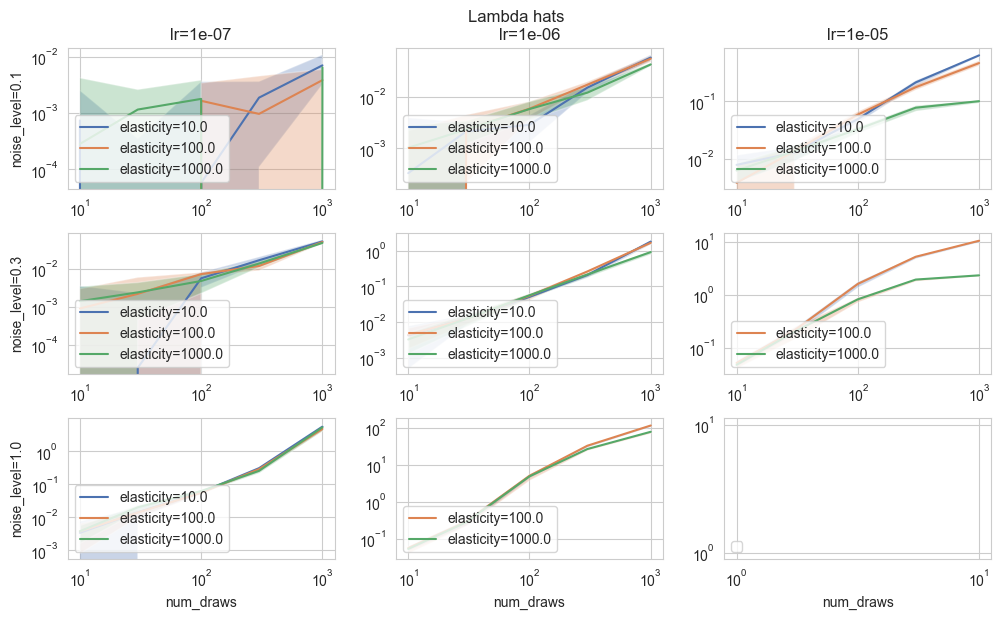

In [61]:
import matplotlib.pyplot as plt

NUM_PARAMS = sum(map(lambda x: x.numel(), learner.model.parameters()))

def plot_rlct_grid(df, col_axis: str, row_axis: str, label_axis: str, x_axis: str, title: str, logscale: bool = True, inset=False, figsize=(10, 6)):
    cols = df[col_axis].unique()
    rows = df[row_axis].unique()
    labels = df[label_axis].unique()
    xs = df[x_axis].unique()

    # Define the colors for each w value
    colors = [PRIMARY, SECONDARY, TERTIARY]

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(len(rows), len(cols), figsize=figsize)

    if len(rows) == 1 and len(cols) == 1:
        axes = np.array([[axes]])
    elif len(rows) == 1: 
        axes = axes.reshape(1, -1)
    elif len(cols) == 1:
        axes = axes.reshape(-1, 1)

    fig.suptitle(title)
    fig.tight_layout()

    # Iterate through the unique gammas
    for i, col in enumerate(cols):
        for j, row in enumerate(rows):
            axes[j, 0].set_ylabel(f"{row_axis}={row}")
            axes[0, i].set_title(f"{col_axis}={col}")
            axes[-1, i].set_xlabel(x_axis)

            ax = axes[j, i]

            for k, label in enumerate(labels):
                data = df[(df[col_axis] == col) & (df[label_axis] == label) & (df[row_axis] == row)]
                color = colors[k]
                
                rlct_mean = data["rlct/mean"]
                rlct_std = data["rlct/std"]

                if rlct_mean.max() > NUM_PARAMS:
                    continue

                # Plot the training error against the number of steps
                ax.plot(data[x_axis], rlct_mean, color=color, label=f'{label_axis}={label}')
                ax.fill_between(xs, rlct_mean-rlct_std, rlct_mean+rlct_std, alpha=0.3)

            if logscale:
                ax.set_yscale('log')
                ax.set_xscale('log')

            ax.legend(loc='lower left') 

    plt.show()


# lr, num_draws, noise_level, elasticity
plot_rlct_grid(grid_search, col_axis="lr", row_axis="noise_level", x_axis="num_draws", label_axis="elasticity", title="Lambda hats")

In [68]:
checkpoint_steps = sorted(list(map(lambda filename: int(str(filename).split("/")[-1].split(".")[0]), CHECKPOINTS_PATH.glob("*.pt"))))
evals_over_time = eval_rlcts_over_time(learner, checkpoint_steps, num_draws=1000, num_chains=1, num_cores=NUM_CORES, lr=1e-6, noise_level=1., weight_decay=3e-7, elasticity=100., repeats=5, pbar=True)

rlct/0,▁
rlct/1,▁
rlct/2,▁
rlct/3,▁
rlct/4,▁
rlct/mean,▁
rlct/std,▁
rlct/0,-1090544.10238
rlct/1,4974583126.84238
rlct/2,-1095200.19739
rlct/3,464535469.37144


Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.44it/s]


rlct/0: -1076022.612389441
rlct/1: -1054982.6960950864
rlct/2: 66154327.386090904
rlct/3: -1111001.9574656803
rlct/4: 3782366701.3189497
rlct/mean: 769055804.2878181
rlct/std: 1506880460.6121142



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.74it/s]


rlct/0: -958250.7928802938
rlct/1: -1118475.4288528177
rlct/2: 2.1412674231859354e+18
rlct/3: 8957218978.728872
rlct/4: -1055052.6100986358
rlct/mean: 4.2825348642800454e+17
rlct/std: 8.565069683789654e+17



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.23it/s]


rlct/0: 590806735691404.1
rlct/1: 23154678116733.12
rlct/2: 455390776642.02515
rlct/3: 4.006420555579203e+16
rlct/4: 18513385509.090744
rlct/mean: 8135728174752464.0
rlct/std: 1.5965837222615244e+16



Chain 0: 100%|██████████| 1000/1000 [01:14<00:00, 13.42it/s]


rlct/0: 84420522265905.47
rlct/1: 78208507879795.12
rlct/2: 10585671937732.695
rlct/3: 144937915223922.78
rlct/4: 725232559101.8042
rlct/mean: 63775569973291.58
rlct/std: 52964819152785.33



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.16it/s]


rlct/0: 20827003100251.957
rlct/1: 5.9100261075731e+16
rlct/2: 1.546139953995687e+31
rlct/3: 1269000336089450.5
rlct/4: 1923250140393970.0
rlct/mean: 3.0922799079913867e+30
rlct/std: 6.184559815982742e+30



Chain 0: 100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s]


rlct/0: 1.1624082032980454e+24
rlct/1: 2.2314989529901013e+20
rlct/2: 294535153766.3506
rlct/3: 3.2678892621509212e+16
rlct/4: 7.960900255446852e+21
rlct/mean: 2.3411845722559566e+23
rlct/std: 4.641549303314312e+23



Chain 0: 100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s]


rlct/0: 354940006340040.56
rlct/1: 9.778278004969368e+17
rlct/2: 4.602720081154702e+16
rlct/3: 2295597540684887.0
rlct/4: 3.360172557566105e+17
rlct/mean: 2.7250455892242387e+17
rlct/std: 3.741350102271585e+17



Chain 0: 100%|██████████| 1000/1000 [01:21<00:00, 12.30it/s]


rlct/0: 68726027149.83414
rlct/1: 3.1354085842839204e+18
rlct/2: 34831748508.905136
rlct/3: 1748511379291866.5
rlct/4: 1053056108566956.0
rlct/mean: 6.27642051065911e+17
rlct/std: 1.253883442373285e+18



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


rlct/0: 662328791590129.9
rlct/1: 2.6424305666599336e+33
rlct/2: 6.682207732939501e+16
rlct/3: 262087912930.4793
rlct/4: 1968866495066.6123
rlct/mean: 5.284861133319867e+32
rlct/std: 1.0569722266639735e+33



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.04it/s]


rlct/0: -7265.708729567356
rlct/1: -6604.494732025537
rlct/2: -5923.446941951286
rlct/3: -7352.3616086739785
rlct/4: -6036.206155893416
rlct/mean: -6636.443633622315
rlct/std: 596.3527734980731



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


rlct/0: 1454.8972983902186
rlct/1: 1476.7806499208393
rlct/2: 1455.2836098875869
rlct/3: 1530.3417783910963
rlct/4: 1448.3330626422
rlct/mean: 1473.1272798463883
rlct/std: 30.173922333308553



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]


rlct/0: -5036.406985572983
rlct/1: -5730.672989143792
rlct/2: -4296.196262934319
rlct/3: -5121.183947133264
rlct/4: -3035.1845718373606
rlct/mean: -4643.928951324344
rlct/std: 924.3160112466168



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.12it/s]


rlct/0: 1419.6363178528725
rlct/1: 1435.8964783549848
rlct/2: 1518.6668765346983
rlct/3: 1470.5792436720358
rlct/4: 1467.0745722036413
rlct/mean: 1462.3706977236466
rlct/std: 34.01728362040662



Chain 0: 100%|██████████| 1000/1000 [01:19<00:00, 12.62it/s]


rlct/0: -10361.076790363493
rlct/1: -10476.652976339836
rlct/2: -8036.012993279445
rlct/3: -15301.839163069573
rlct/4: -9474.768156493736
rlct/mean: -10730.070015909218
rlct/std: 2446.8418555682274



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.91it/s]


rlct/0: 1270.346132816964
rlct/1: 1270.497787186347
rlct/2: 1271.9352847354464
rlct/3: 1288.7489116387997
rlct/4: 1275.0607393170733
rlct/mean: 1275.317771138926
rlct/std: 6.926070280643061



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]


rlct/0: 1295.8866343373154
rlct/1: 1318.7114394592938
rlct/2: 1318.070603913546
rlct/3: 1338.9617807097038
rlct/4: 1336.3498411731623
rlct/mean: 1321.5960599186042
rlct/std: 15.498172530072567



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s]


rlct/0: 282.0437021465578
rlct/1: 101.32662996142261
rlct/2: 214.7435427770518
rlct/3: 214.31041423659883
rlct/4: 260.89862698512724
rlct/mean: 214.66458322135162
rlct/std: 62.487047920859325



Chain 0: 100%|██████████| 1000/1000 [01:18<00:00, 12.77it/s]


rlct/0: 1507.5791926550598
rlct/1: 1512.9637428113374
rlct/2: 1520.6306315007912
rlct/3: 1504.50117619174
rlct/4: 1490.787597326559
rlct/mean: 1507.2924680970975
rlct/std: 9.90307265946522



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.02it/s]


rlct/0: -199.54340434363567
rlct/1: -50.629741053882874
rlct/2: -146.98613514472413
rlct/3: -104.43176036355429
rlct/4: -122.61175760317155
rlct/mean: -124.8405597017937
rlct/std: 48.98912892244188



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.95it/s]


rlct/0: 1408.1353288233636
rlct/1: 1380.079104211469
rlct/2: 1430.7869840220712
rlct/3: 1382.4383798504014
rlct/4: 1448.3311959583928
rlct/mean: 1409.9541985731396
rlct/std: 26.682386355560137



Chain 0: 100%|██████████| 1000/1000 [01:16<00:00, 13.01it/s]


rlct/0: 5.483639585088347e+23
rlct/1: 3.0666053836780425e+30
rlct/2: 1.3796783843794215e+25
rlct/3: 9.722619103723534e+17
rlct/4: 7.111754224427093e+19
rlct/mean: 6.133239457795869e+29
rlct/std: 1.2266407189605763e+30



Chain 0: 100%|██████████| 1000/1000 [01:17<00:00, 12.90it/s]


rlct/0: 533.4241032642008
rlct/1: 577.6710825359023
rlct/2: 544.5751652302604
rlct/3: 594.9126226733525
rlct/4: 612.9391987537449
rlct/mean: 572.7044344914923
rlct/std: 29.902868360254736



Chain 0: 100%|██████████| 1000/1000 [01:15<00:00, 13.29it/s]


rlct/0: 1390.8921642681453
rlct/1: 1381.7111230832893
rlct/2: 1437.5108479560074
rlct/3: 1417.9499149344372
rlct/4: 1379.4197905281324
rlct/mean: 1401.4967681540024
rlct/std: 22.62318411938095



Chain 0: 100%|██████████| 1000/1000 [17:27<00:00,  1.05s/it]  


rlct/0: 231.13689501912282
rlct/1: 170.78583218649567
rlct/2: 255.24101268152776
rlct/3: 216.5854136649507
rlct/4: 236.9549425962463
rlct/mean: 222.14081922966867
rlct/std: 28.51037587431371



Chain 0: 100%|██████████| 1000/1000 [13:20<00:00,  1.25it/s]   


rlct/0: 1417.4001303317102
rlct/1: 1384.1430993897907
rlct/2: 1435.2247368926471
rlct/3: 1394.2168772391633
rlct/4: 1402.9316955155084
rlct/mean: 1406.783307873764
rlct/std: 17.9274144292477



Chain 0: 100%|██████████| 1000/1000 [17:23<00:00,  1.04s/it]   


rlct/0: 1.0097719535856591e+20
rlct/1: 1.2577857278534722e+30
rlct/2: 1.3085163365203768e+18
rlct/3: 3.2534778985792668e+16
rlct/4: 1051.6265640784527
rlct/mean: 2.515571455911581e+29
rlct/std: 5.0311429113115706e+29



Chain 0: 100%|██████████| 1000/1000 [15:21<00:00,  1.09it/s]   


rlct/0: 409.89332274801035
rlct/1: 360.95882749233584
rlct/2: 382.3064749238547
rlct/3: 448.3521533267589
rlct/4: 427.7341770517238
rlct/mean: 405.8489911085368
rlct/std: 31.21286157506784



Chain 0: 100%|██████████| 1000/1000 [22:51<00:00,  1.37s/it]   


rlct/0: 1346.2521014404563
rlct/1: 1377.87945941445
rlct/2: 1344.786543883252
rlct/3: 1339.9372936155912
rlct/4: 1346.347664207438
rlct/mean: 1351.0406125122377
rlct/std: 13.621118676916165



Chain 0:  40%|███▉      | 397/1000 [33:47<13:39:11, 81.51s/it]